In [15]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# A Simple Starter Code for the AJL Competition

@Cindy Deng

---


Hi! This starter code is designed to help you get familiar with basic Kaggle operations and guide you through the basic workflow of a machine learning project. 

The code outlines essential steps including data loading, preprocessing, model building, training, and generating predictions. Each section serves as a foundation, but there are many ways to enhance each step to improve your final model's accuracy. Feel free to experiment with different data augmentation techniques, model architectures, and tuning methods to optimize your final results! Some amazing tutorials are available through your AI Studio course in Canvas / in the 'Resource' section of this Kaggle competition.

Good luck and have fun!

---

## Note - About file path

You could use the cell above to print the names of the file directories and get the following directories:

```
/kaggle/input/bttai-ajl-2025/sample_submission.csv
/kaggle/input/bttai-ajl-2025/train.csv
/kaggle/input/bttai-ajl-2025/test.csv
/kaggle/input/bttai-ajl-2025/test/test/e0374ae6c1362ff183cfba28ded5421b.jpg
/kaggle/input/bttai-ajl-2025/test/test/437159c605260bdd079af230566af291.jpg
...
...
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/11271bdf2598afdd4260db3125e1f6a5.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/732819951dcf2b53d15ea7b8bb123b71.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/6dcc7a8abb5e1c6e670101f4b6231246.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/e63c3b3f0ab8905e204fe467cc7411f9.jpg
...
...
```



## 1. Import Necessary Libraries

In [16]:
# 1. Import Necessary Libraries
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Explanation:
# - pandas and numpy: for data manipulation
# - sklearn: for splitting data and encoding labels
# - tensorflow.keras: for building and training the neural network


# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# For Transfer Learning (e.g., MobileNetV2, Xception, or EfficientNet)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

# For plotting 
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Load Data

Make sure to verify the file paths if you're running on a different platform.

In [17]:
# 2. Load Data
train_df = pd.read_csv('/kaggle/input/bttai-ajl-2025/train.csv')
test_df = pd.read_csv('/kaggle/input/bttai-ajl-2025/test.csv')

# Add .jpg extension to md5hash column to reference the file_name
train_df['md5hash'] = train_df['md5hash'].astype(str) + '.jpg'
test_df['md5hash'] = test_df['md5hash'].astype(str) + '.jpg'

# Combine label and md5hash to form the correct path
train_df['file_path'] = train_df['label'] + '/' + train_df['md5hash']

In [18]:
# Checking the first few rows to understand the structure
print(train_df.head())

                                md5hash  fitzpatrick_scale  \
0  fd06d13de341cc75ad679916c5d7e6a6.jpg                  4   
1  a4bb4e5206c4e89a303f470576fc5253.jpg                  1   
2  c94ce27e389f96bda998e7c3fa5c4a2e.jpg                  5   
3  ebcf2b50dd943c700d4e2b586fcd4425.jpg                  3   
4  c77d6c895f05fea73a8f3704307036c0.jpg                  1   

   fitzpatrick_centaur                             label nine_partition_label  \
0                    4                 prurigo-nodularis     benign-epidermal   
1                    1  basal-cell-carcinoma-morpheiform  malignant-epidermal   
2                    5                            keloid         inflammatory   
3                    3              basal-cell-carcinoma  malignant-epidermal   
4                    1                 prurigo-nodularis     benign-epidermal   

  three_partition_label            qc  ddi_scale  \
0                benign           NaN         34   
1             malignant           Na

## 3. Data Preprocessing


This section demonstrates basic preprocessing techniques. To enhance data quality and model performance, consider incorporating more advanced preprocessing methods.

For further guidance, feel free to take a look at the [Image Preprocessing tutorial](https://colab.research.google.com/drive/1-ItNcRMbZBE6BCwPT-wD8m3YmHqwHxme?usp=sharing)  available in the 'Resources' section of this Kaggle competition.


In [19]:
# fixing any negative Fitzpatrick scale (just in case)
def fix_negative_fst(df, scale_col='fitzpatrick_scale'):
    """to negative or <1 scale to 0, representing 'Unknown'.    """
    df[scale_col] = df[scale_col].apply(lambda x: 0 if x < 1 else x)
    return df

train_df = fix_negative_fst(train_df)

In [20]:
# 3. Data Preprocessing
# Encode the labels
label_encoder = LabelEncoder()
train_df['encoded_label'] = label_encoder.fit_transform(train_df['label'])
print("Unique labels in training data:", label_encoder.classes_)
num_classes = len(label_encoder.classes_)

Unique labels in training data: ['acne' 'acne-vulgaris' 'actinic-keratosis' 'basal-cell-carcinoma'
 'basal-cell-carcinoma-morpheiform' 'dermatofibroma' 'dermatomyositis'
 'dyshidrotic-eczema' 'eczema' 'epidermal-nevus' 'folliculitis'
 'kaposi-sarcoma' 'keloid' 'malignant-melanoma' 'melanoma'
 'mycosis-fungoides' 'prurigo-nodularis' 'pyogenic-granuloma'
 'seborrheic-keratosis' 'squamous-cell-carcinoma'
 'superficial-spreading-melanoma-ssm']


Null values by column:
md5hash                     0
fitzpatrick_scale           0
fitzpatrick_centaur         0
label                       0
nine_partition_label        0
three_partition_label       0
qc                       2770
ddi_scale                   0
file_path                   0
encoded_label               0
dtype: int64

Label distribution:
 label
squamous-cell-carcinoma               407
basal-cell-carcinoma                  328
folliculitis                          239
acne-vulgaris                         234
melanoma                              181
eczema                                143
acne                                  128
mycosis-fungoides                     127
actinic-keratosis                     122
prurigo-nodularis                     119
kaposi-sarcoma                        109
keloid                                109
dermatomyositis                       106
superficial-spreading-melanoma-ssm     83
pyogenic-granuloma                     79
malign

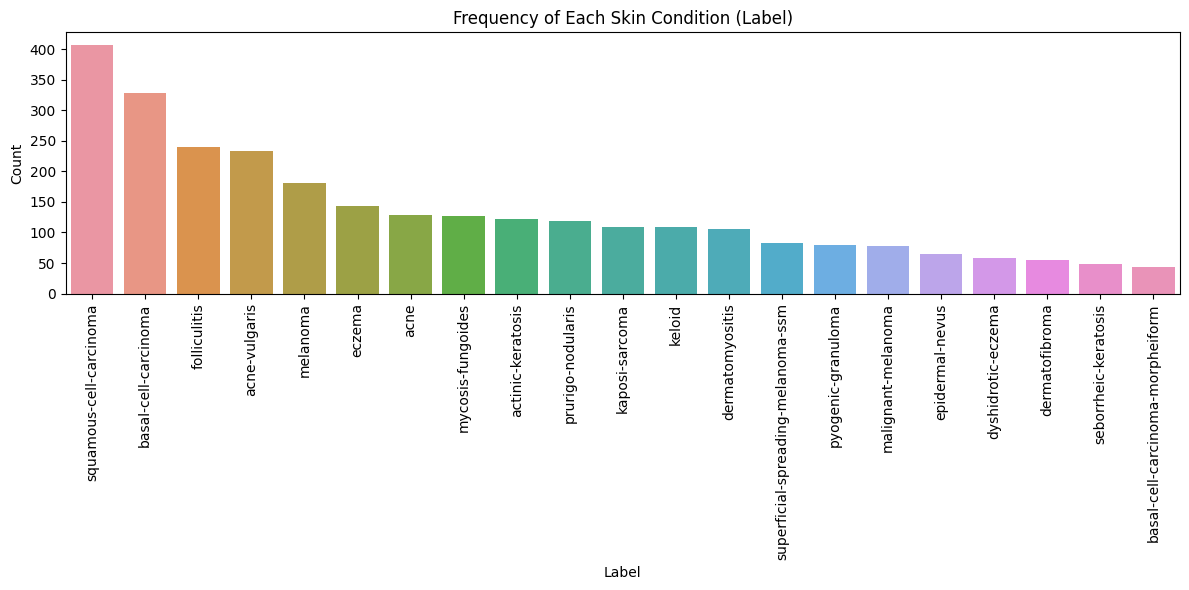


Fitzpatrick Scale distribution:
 fitzpatrick_scale
2    964
3    562
1    528
4    393
5    216
0    108
6     89
Name: count, dtype: int64


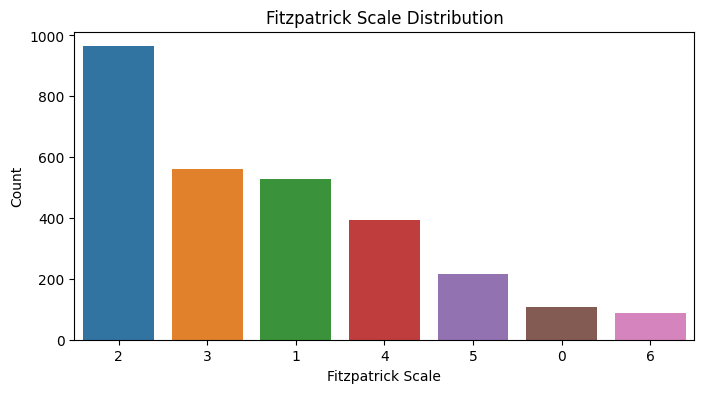


Label x Fitzpatrick distribution (before balancing):
                 label  fitzpatrick_scale  count
0                acne                  1     32
1                acne                  2     48
2                acne                  3     22
3                acne                  4     15
4                acne                  5     11
5       acne-vulgaris                  1     53
6       acne-vulgaris                  2    104
7       acne-vulgaris                  3     34
8       acne-vulgaris                  4     30
9       acne-vulgaris                  5      9
10      acne-vulgaris                  6      4
11  actinic-keratosis                  0      5
12  actinic-keratosis                  1     21
13  actinic-keratosis                  2     55
14  actinic-keratosis                  3     18


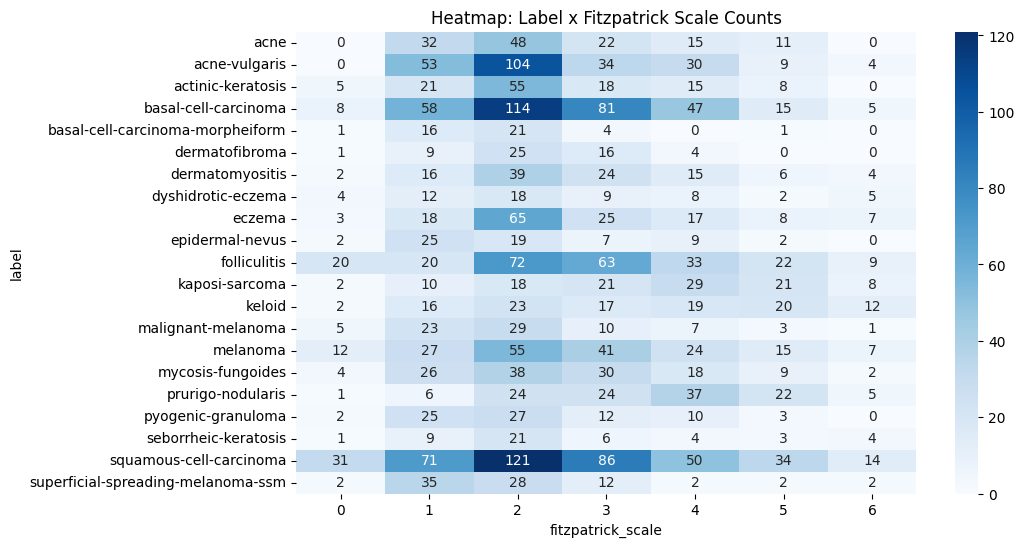


No classes with <20 samples in the raw data.


In [21]:
#   Data Understanding
# =========================

# overview of null/missing values: 
print("Null values by column:")
print(train_df.isnull().sum())

# class distribution: 
label_counts = train_df['label'].value_counts()
print("\nLabel distribution:\n", label_counts)

# bar chart to visualize the class distribution:
plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks(rotation=90)
plt.title("Frequency of Each Skin Condition (Label)")
plt.ylabel("Count")
plt.xlabel("Label")
plt.tight_layout()
plt.show()

# Distribution of Fitzpatrick Scale (to see if any balancing needs to be done)
fst_counts = train_df['fitzpatrick_scale'].value_counts()
print("\nFitzpatrick Scale distribution:\n", fst_counts)

# another bar plot to see that as well 
plt.figure(figsize=(8, 4))
sns.barplot(x=fst_counts.index.astype(str), y=fst_counts.values)
plt.title("Fitzpatrick Scale Distribution")
plt.xlabel("Fitzpatrick Scale")
plt.ylabel("Count")
plt.show()

# combining Label & Fitzpatrick to see if certain conditions are especially rare in certain skin tones:
grouped = train_df.groupby(['label', 'fitzpatrick_scale']).size().reset_index(name='count')
print("\nLabel x Fitzpatrick distribution (before balancing):\n", grouped.head(15)) 

# pivot table for a quick cross-tab:
pivot = grouped.pivot(index='label', columns='fitzpatrick_scale', values='count').fillna(0)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='Blues')
plt.title("Heatmap: Label x Fitzpatrick Scale Counts")
plt.show()

# checking for extremely rare classes
rare_labels = label_counts[label_counts < 20].index
if len(rare_labels) > 0:
    print("\nRare classes (<20 samples):", list(rare_labels))
else:
    print("\nNo classes with <20 samples in the raw data.")

In [25]:
# FAIRNESS-AWARE BALANCING / SAMPLING (v1)
# -----------------------------------------------------------------------------
# The dataset has a 'fitzpatrick_scale' (1..6 or possibly missing/negative).
# can attempt to balance the data across FST categories to ensure we train fairly.

# strategies:
#   -> grouping by (fitzpatrick_scale) or a combined factor (fitz + label).
#   -> finding the group with the maximum # of samples or a target size.
#   ->  randomly oversample the smaller groups, or undersample the largest groups, etc.

# This will be "random oversample" approach:

# def balance_by_fitzpatrick(dataframe, scale_col='fitzpatrick_scale'):
#     """
#     Example function to oversample so that each Fitzpatrick scale is equally represented.
#     If some scale is missing or negative, we skip or handle carefully.
#     """
#     # Exclude negative or unknown FST, e.g., scale <1 or scale>6
#     df_valid = dataframe[(dataframe[scale_col] >= 1) & (dataframe[scale_col] <= 6)]
    
#     # group by the scale
#     groups = df_valid.groupby(scale_col)
#     max_size = groups.size().max()  # the largest group count
#     print(f"FST distribution before balancing:\n{groups.size()}")
    
#     # oversample smaller groups up to max_size
#     balanced_list = []
#     for fst_val, subset in groups:
#         oversampled_subset = subset.sample(n=max_size, replace=True, random_state=42)
#         balanced_list.append(oversampled_subset)
#     df_balanced = pd.concat(balanced_list).reset_index(drop=True)
    
#     print(f"FST distribution AFTER balancing:\n{df_balanced.groupby(scale_col).size()}")
    
#     # combine  with the part that wasn't in [1..6] 
#     # we might just add them without balancing
#     df_outside = dataframe[(dataframe[scale_col] < 1) | (dataframe[scale_col] > 6)]
#     final_df = pd.concat([df_balanced, df_outside], ignore_index=True)
#     return final_df

# train_df = balance_by_fitzpatrick(train_df, scale_col='fitzpatrick_scale')
# train_df

In [26]:
# FAIRNESS-AWARE BALANCING / SAMPLING

# grouping not only by scale but also by label, so we can try to make it fair from both sides 

def balance_by_label_and_scale(df, label_col='encoded_label', scale_col='fitzpatrick_scale'): 
    """
    Oversample each (label, scale) pair to match the maximum count among pairs.
    """
    grouped = df.groupby([label_col, scale_col]) # grouping by both, for every combination
    max_count = grouped.size().max() # finding the largest combination
    oversampled_pieces = []
    for (lbl, fst), subset in grouped:
        # finding how many more do we need to reach max_count:
        size_needed = max_count - len(subset)
        oversampled_pieces.append(subset)  # original
        if size_needed > 0:
            # sample with replacement to bring up the number
            extra = subset.sample(n=size_needed, replace=True, random_state=42)
            oversampled_pieces.append(extra)
    df_oversampled = pd.concat(oversampled_pieces, ignore_index=True)
    return df_oversampled

train_df = balance_by_label_and_scale(train_df)
train_df

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,ddi_scale,file_path,encoded_label
0,117f28ca4f0e09883b89b8b0f740c16c.jpg,1,1,acne,inflammatory,non-neoplastic,NaN,12,acne/117f28ca4f0e09883b89b8b0f740c16c.jpg,0
1,4235913d0b8803702095b54856a07702.jpg,1,1,acne,inflammatory,non-neoplastic,NaN,12,acne/4235913d0b8803702095b54856a07702.jpg,0
2,92c24a166a74b8bb86274701643548e8.jpg,1,1,acne,inflammatory,non-neoplastic,NaN,12,acne/92c24a166a74b8bb86274701643548e8.jpg,0
3,92263f85d6f3398535bdf5535d78a827.jpg,1,1,acne,inflammatory,non-neoplastic,NaN,12,acne/92263f85d6f3398535bdf5535d78a827.jpg,0
4,a25974f39c1d2238cd71a9e4e10702e0.jpg,1,1,acne,inflammatory,non-neoplastic,NaN,12,acne/a25974f39c1d2238cd71a9e4e10702e0.jpg,0
...,...,...,...,...,...,...,...,...,...,...
16572,02f11821915d67f20fb15a8e8b96c1d3.jpg,6,1,superficial-spreading-melanoma-ssm,malignant-melanoma,malignant,NaN,56,superficial-spreading-melanoma-ssm/02f11821915...,20
16573,454e68bf5705eabf0f4d28fc1dbd77be.jpg,6,1,superficial-spreading-melanoma-ssm,malignant-melanoma,malignant,1 Diagnostic,56,superficial-spreading-melanoma-ssm/454e68bf570...,20
16574,02f11821915d67f20fb15a8e8b96c1d3.jpg,6,1,superficial-spreading-melanoma-ssm,malignant-melanoma,malignant,NaN,56,superficial-spreading-melanoma-ssm/02f11821915...,20
16575,454e68bf5705eabf0f4d28fc1dbd77be.jpg,6,1,superficial-spreading-melanoma-ssm,malignant-melanoma,malignant,1 Diagnostic,56,superficial-spreading-melanoma-ssm/454e68bf570...,20


In [27]:
# checking the distribution again: 
# optional: check the new distribution
label_counts = train_df['encoded_label'].value_counts()
print("Label counts after oversampling:\n", label_counts)
fst_counts = train_df['fitzpatrick_scale'].value_counts()
print("Fitzpatrick scale counts after oversampling:\n", fst_counts)

Label counts after oversampling:
 encoded_label
10    847
11    847
19    847
18    847
16    847
15    847
14    847
13    847
12    847
20    847
8     847
7     847
6     847
3     847
1     726
9     726
17    726
2     726
5     605
4     605
0     605
Name: count, dtype: int64
Fitzpatrick scale counts after oversampling:
 fitzpatrick_scale
1    2541
2    2541
3    2541
4    2420
5    2420
0    2299
6    1815
Name: count, dtype: int64


In [28]:
# TRAIN/VALIDATION SPLIT
# -----------------------------------------------------------------------------
# can try 80/20 split. also, can stratify by 'encoded_label' to keep
# class distribution consistent.

train_data, val_data = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=train_df['encoded_label']  # keep label distribution consistent
)
print("Train set size:", train_data.shape[0])
print("Val set size:  ", val_data.shape[0])

Train set size: 13261
Val set size:   3316


In [29]:
# using class weights (to pass in later)
# -----------------------------------------------------------------------------
labels_array = train_data['encoded_label'].values
cw_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_array),
    y=labels_array
)
class_weights = dict(enumerate(cw_array))
print("Class weights:", class_weights)

Class weights: {0: 1.304702872884691, 1: 1.0868781247438735, 2: 1.0868781247438735, 3: 0.9313808119117853, 4: 1.304702872884691, 5: 1.304702872884691, 6: 0.9313808119117853, 7: 0.9327565590490258, 8: 0.9313808119117853, 9: 1.0868781247438735, 10: 0.9327565590490258, 11: 0.9313808119117853, 12: 0.9327565590490258, 13: 0.9327565590490258, 14: 0.9313808119117853, 15: 0.9327565590490258, 16: 0.9327565590490258, 17: 1.0868781247438735, 18: 0.9313808119117853, 19: 0.9327565590490258, 20: 0.9313808119117853}


In [31]:
# IMAGE DATA AUGMENTATION
# -----------------------------------------------------------------------------
# applying advanced transformations for training, minimal for validation:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.15,
    brightness_range=[0.8, 1.2], # additional changes for brightness
    channel_shift_range=20.0 # changes for channel
)
val_datagen = ImageDataGenerator(
    rescale=1./255
)

In [32]:
# BUILDING THE GENERATOR FUNCTION
# -----------------------------------------------------------------------------
train_dir = '/kaggle/input/bttai-ajl-2025/train/train/'  # base path to images

def create_generator(
    dataframe,
    directory,
    datagen,
    x_col='file_path',
    y_col='encoded_label',
    target_size=(128,128),
    batch_size=32,
    class_mode='raw',      # 'raw' => returns numeric labels as is
    shuffle=True
):
    """
    Creates a Keras image generator from a dataframe.
    
    directory: base path to the image files
    x_col: which column in df has the relative file path (label/fn.jpg)
    y_col: which column has the numeric label
    """
    gen = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col=x_col,
        y_col=y_col,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=shuffle,
        validate_filenames=False  # skip verifying existence 
    )
    return gen

In [33]:
# CREATING THE TRAINING & VALIDATION GENERATORS
# -----------------------------------------------------------------------------
train_generator = create_generator(
    dataframe=train_data,
    directory=train_dir,
    datagen=train_datagen,
    target_size=(128,128),
    batch_size=32,
    shuffle=True
)

val_generator = create_generator(
    dataframe=val_data,
    directory=train_dir,
    datagen=val_datagen,
    target_size=(128,128),
    batch_size=32,
    shuffle=False
)

print("Data preprocessing (with fairness adjustments) complete!")

Found 13261 non-validated image filenames.
Found 3316 non-validated image filenames.
Data preprocessing (with fairness adjustments) complete!


## 4. Build the model


In [34]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

num_classes = len(label_encoder.classes_)  # from earlier
print("Number of classes:", num_classes)

# LOAD PRETRAINED BASE MODEL
# -----------------------------------------------------------------------------
# setting 'include_top=False' to discard MobileNet's classifier
# and feed in the (128,128,3) images. 
# By default, MobileNetV2 expects (224,224,3), but it can adapt to (128,128) 
# can still do 'weights="imagenet"' for pre-trained on large dataset.

base_model = MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights="imagenet"  # using pretrained weights from ImageNet
)

# freezing the base model, so initially this only trains new layers
base_model.trainable = False


# BUILD TOP LAYERS
# -----------------------------------------------------------------------------
# pipeline:
#   1) base_model
#   2) GlobalAveragePooling2D to reduce
#   3) Dropout for regularization
#   4) Dense(num_classes) with softmax for multi-class

model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),               # increase dropout to 0.3
    layers.Dense(256, activation='relu'),  # an additional Dense layer
    layers.Dropout(0.3),               # dropout again
    layers.Dense(num_classes, activation='softmax')
])
model.summary()

Number of classes: 21
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 21)                  │           5,397 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,591,317 (9.89 MB)

 Trainable params: 333,333 (1.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 5. Train the Model


In [36]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# setting up callbacks for best practices:
#   - EarlyStopping: stop if val accuracy doesn’t improve
#   - ModelCheckpoint: keep the best model weights

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]

# fit using the train_generator and val_generator
epochs = 10  # for now, just to try it out (can change later)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weights  # if we're using... 
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


415/415 ━━━━━━━━━━━━━━━━━━━━ 147s 339ms/step - accuracy: 0.2569 - loss: 2.5843 - val_accuracy: 0.5968 - val_loss: 1.3980
Epoch 2/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 131s 311ms/step - accuracy: 0.5448 - loss: 1.4945 - val_accuracy: 0.6915 - val_loss: 1.0880
Epoch 3/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 130s 309ms/step - accuracy: 0.6312 - loss: 1.2171 - val_accuracy: 0.7307 - val_loss: 0.9164
Epoch 4/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 130s 309ms/step - accuracy: 0.6721 - loss: 1.0782 - val_accuracy: 0.7642 - val_loss: 0.7962
Epoch 5/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 132s 315ms/step - accuracy: 0.7018 - loss: 0.9641 - val_accuracy: 0.7859 - val_loss: 0.7174
Epoch 6/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 133s 317ms/step - accuracy: 0.7291 - loss: 0.8807 - val_accuracy: 0.7925 - val_loss: 0.6932
Epoch 7/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 129s 306ms/step - accuracy: 0.7350 - loss: 0.8460 - val_accuracy: 0.8007 - val_loss: 0.6492
Epoch 8/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 129s 307ms/step - accuracy: 0.7510 - loss: 0.79

## 6. Make Predictions on Test Data

In [38]:
from sklearn.metrics import f1_score
import numpy as np

# predictions for the validation set
val_preds = model.predict(val_generator)
# shape: (#val_samples, num_classes)

# converting from probabilities to class indices
val_pred_classes = np.argmax(val_preds, axis=1)

# true labels from 'val_data' (in the same order as val_generator)
# used flow_from_dataframe(shuffle=False) for val_generator,
# can directly map if the generator and dataframe are in sync.

y_true = val_data['encoded_label'].values

# weighted F1:
val_f1 = f1_score(y_true, val_pred_classes, average='weighted')
print("Validation Weighted F1 Score:", val_f1)

104/104 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step
Validation Weighted F1 Score: 0.7556207550149454


In [39]:
# 6. Make Predictions on Test Data
def create_test_generator(dataframe, directory, target_size=(128,128), batch_size=32):
    """
    Creates a generator for unlabeled test images. 
    We assume 'md5hash' or a 'file_path' column for x_col, 
    but y_col=None because there's no label.
    """
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col='md5hash',   # also 'file_path' ... but can do 'md5hash'
        y_col=None,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,   # no labels
        shuffle=False,     # keeping he same order as test_df
        validate_filenames=False
    )
    return test_gen


In [40]:
# Load test data
test_dir = '/kaggle/input/bttai-ajl-2025/test/test/'

test_generator = create_test_generator(
    dataframe=test_df,
    directory=test_dir,
    target_size=(128,128)  # must match train/val --> used 128
)

Found 1227 non-validated image filenames.


## 7. Generate Predictions

In [41]:
test_probs = model.predict(test_generator)
# shape => (# test samples, num_classes)

test_pred_classes = np.argmax(test_probs, axis=1)

# numeric class predictions --> strings
test_pred_labels = label_encoder.inverse_transform(test_pred_classes)

# building submission DataFrame
submission_df = pd.DataFrame({
    # removing '.jpg' from the hash so it matches the competition’s expected ID
    "md5hash": test_df['md5hash'].str.replace('.jpg','', regex=False),
    "label": test_pred_labels
})
print(submission_df.head())

# saving to CSV
submission_df.to_csv("submission.csv", index=False)
print("Submission CSV is ready: submission.csv")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 303ms/step
                            md5hash                    label
0  0844ae634f0e6e7ef1f73c2aeecbae0e        prurigo-nodularis
1  3b290d262098f761d719aa07cf36c040  squamous-cell-carcinoma
2  cf561d08ac46d0fda678bff6621005ee     basal-cell-carcinoma
3  e6371069be05c6b0a95b4b3f1bacc9a5            acne-vulgaris
4  f76cddb37265f97508f159078dcc7e7c             folliculitis
Submission CSV is ready: submission.csv
